In [51]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime,timedelta

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,cross_validate
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost.sklearn import XGBRegressor

from scipy.signal import find_peaks as findPeaks

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.style.use('ggplot')
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

import xgboost as xgb

In [2]:
def mape(label, pred):
    return np.mean(np.abs(label - pred).astype(np.float64) / label)

In [3]:
def base_pred(train_data,train_label):
    
    train_data =  train_data
    train_label = train_label
    
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.2, random_state=123)
    
    data_dmatrix = xgb.DMatrix(train_data ,label=train_label)
    
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', eta = 0.02, min_child_weight = 8,
                subsample = 0.9, colsample_bytree = 0.8, max_depth = 8,
                seed=1, silent=1)
    
    xg_reg.fit(X_train,y_train)
    
    preds = xg_reg.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE: %f" % (rmse))
    
    test_err = mape(y_test, preds)
    print ("MAPE: %f" % (test_err))
    
    return rmse, test_err

<h2> Baseline Model </h2>

In [4]:
#read train data
train = pd.read_csv('training_20min_avg_travel_time.csv') 
train.head(2)

,intersection_id,tollgate_id,time_window,averagetravltime,lag1,lag2,lag3,lag4,lag5,lag6,...,wind_speed,temperature,rel_humidity,precipitation,link_count,route_length,in_link,out_link,min_width,hour
0,B,3,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,119.257934,119.256358,119.256739,119.256667,119.255553,119.257916,...,1.9,31.8,64.0,0.0,5,477,2,1,3,0
1,A,2,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",58.05,70.850000,119.256358,119.256739,119.256667,119.255553,119.257916,...,1.9,31.8,64.0,0.0,6,384,0,1,3,0


In [5]:
cat_columns = ["intersection_id","tollgate_id"]
df_train = pd.get_dummies(train, prefix_sep="__",
                              columns=cat_columns)

In [6]:
print(df_train.shape)

(25592, 35)


In [7]:
df_train.head(2)

,time_window,averagetravltime,lag1,lag2,lag3,lag4,lag5,lag6,lag7,date,...,in_link,out_link,min_width,hour,intersection_id__A,intersection_id__B,intersection_id__C,tollgate_id__1,tollgate_id__2,tollgate_id__3
0,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,119.257934,119.256358,119.256739,119.256667,119.255553,119.257916,119.255205,2016-07-19,...,2,1,3,0,0,1,0,0,0,1
1,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",58.05,70.850000,119.256358,119.256739,119.256667,119.255553,119.257916,119.255205,2016-07-19,...,0,1,3,0,1,0,0,0,1,0


In [8]:
train_label = df_train['averagetravltime']

In [9]:
train_data = df_train
train_data.drop(['averagetravltime','time_window','date','month','day','hour','minute'], axis=1, inplace=True)

In [10]:
result = base_pred(train_data,train_label)

C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 38.694482
MAPE: 0.242141


<h2> Study Travel Time Pattern </h2>

In [11]:
#read train data
train = pd.read_csv('training_20min_avg_travel_time.csv') 
train.head(2)

,intersection_id,tollgate_id,time_window,averagetravltime,lag1,lag2,lag3,lag4,lag5,lag6,...,wind_speed,temperature,rel_humidity,precipitation,link_count,route_length,in_link,out_link,min_width,hour
0,B,3,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,119.257934,119.256358,119.256739,119.256667,119.255553,119.257916,...,1.9,31.8,64.0,0.0,5,477,2,1,3,0
1,A,2,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",58.05,70.850000,119.256358,119.256739,119.256667,119.255553,119.257916,...,1.9,31.8,64.0,0.0,6,384,0,1,3,0


In [12]:
print (train['averagetravltime'].describe())

count    25592.000000
mean       119.259518
std         57.578289
min         10.600000
25%         77.750000
50%        109.390000
75%        148.172500
max        567.330000
Name: averagetravltime, dtype: float64


In [13]:
(prmPks0,_) = findPeaks(train['averagetravltime'],prominence=300)

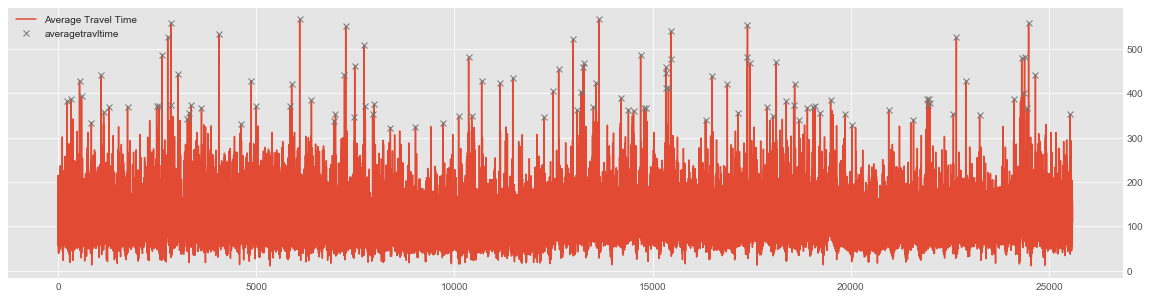

In [14]:
plt.figure(figsize=(20, 5))

plt.plot(train['averagetravltime'], color="C0",label='Average Travel Time')
plt.plot(prmPks0, train['averagetravltime'].iloc[prmPks0],'x', color="C3")
plt.legend()

In [15]:
print(prmPks0)

[  224   332   545   596   843  1083  1153  1288  1756  2490  2549  2629
  2769  2841  2855  3034  3266  3308  3356  3621  4057  4624  4877  4999
  5858  5895  6098  6394  6958  7001  7228  7259  7479  7486  7720  7750
  7938  7967  8386  9019  9710 10107 10359 10437 10688 11144 11472 12256
 12488 12630 12989 13094 13192 13240 13274 13507 13575 13650 14199 14390
 14519 14698 14780 14834 15331 15336 15341 15399 15456 15461 16335 16500
 16885 17151 17389 17393 17454 17879 18037 18115 18372 18559 18582 18692
 18904 19048 19098 19230 19490 19853 20024 20955 21581 21924 21941 21976
 21993 22587 22662 22899 23248 24116 24310 24364 24382 24435 24484 24656
 25524]


<p> Even After Tuning, the data at festival season is still noisy. <p>

In [16]:
#Adjust the data again, not removed because there is limited data
for k, row in train.iterrows():
    if row['averagetravltime'] > 300:
        last_value = train.loc[k-1,'averagetravltime']
        next_value = train.loc[k+1,'averagetravltime']
        if last_value < 300:
            train.loc[k, 'averagetravltime'] = (last_value + next_value)/2.0
        else:
            train.loc[k, 'averagetravltime'] = last_value

In [17]:
print (train['averagetravltime'].describe())

count    25592.000000
mean       116.800404
std         51.760992
min         10.600000
25%         77.599808
50%        108.935000
75%        146.645000
max        329.327667
Name: averagetravltime, dtype: float64


In [18]:
(prmPks0,_) = findPeaks(train['averagetravltime'],prominence=200)

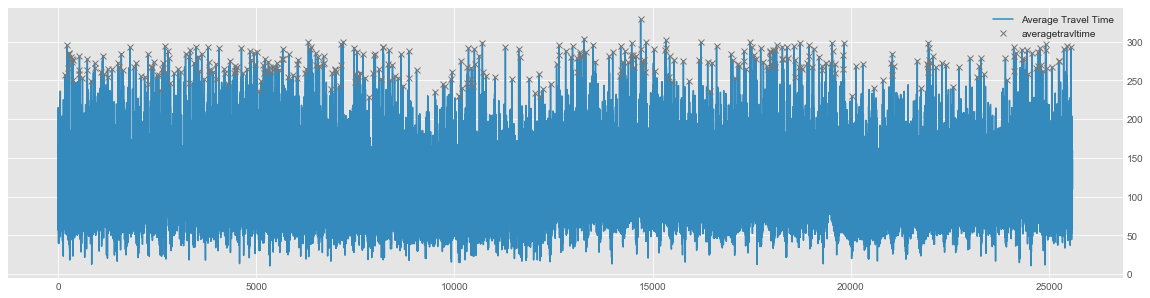

In [19]:
plt.figure(figsize=(20, 5))

plt.plot(train['averagetravltime'], color="C1",label='Average Travel Time')
plt.plot(prmPks0, train['averagetravltime'].iloc[prmPks0],'x', color="C3")
plt.legend()

In [20]:
cat_columns = ["intersection_id","tollgate_id"]
df_train = pd.get_dummies(train, prefix_sep="__",
                              columns=cat_columns)
train_data = df_train
train_data.drop(['averagetravltime','time_window','date','month','day','hour','minute'], axis=1, inplace=True)

In [21]:
result = base_pred(train_data,train_label)

C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 38.694482
MAPE: 0.242141


<p> The level of noise has almost no influence on the data </p>

<h2> Study the Features - Hours </h2>

In [22]:
#read train data
train = pd.read_csv('training_20min_avg_travel_time.csv') 
train.head(2)

,intersection_id,tollgate_id,time_window,averagetravltime,lag1,lag2,lag3,lag4,lag5,lag6,...,wind_speed,temperature,rel_humidity,precipitation,link_count,route_length,in_link,out_link,min_width,hour
0,B,3,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,119.257934,119.256358,119.256739,119.256667,119.255553,119.257916,...,1.9,31.8,64.0,0.0,5,477,2,1,3,0
1,A,2,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",58.05,70.850000,119.256358,119.256739,119.256667,119.255553,119.257916,...,1.9,31.8,64.0,0.0,6,384,0,1,3,0


In [23]:
cat_columns = ["intersection_id","tollgate_id","hour"]
df_train = pd.get_dummies(train, prefix_sep="__",
                              columns=cat_columns)
df_train.head()

,time_window,averagetravltime,lag1,lag2,lag3,lag4,lag5,lag6,lag7,date,...,hour__14,hour__15,hour__16,hour__17,hour__18,hour__19,hour__20,hour__21,hour__22,hour__23
0,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,119.257934,119.256358,119.256739,119.256667,119.255553,119.257916,119.255205,2016-07-19,...,0,0,0,0,0,0,0,0,0,0
1,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",58.05,70.850000,119.256358,119.256739,119.256667,119.255553,119.257916,119.255205,2016-07-19,...,0,0,0,0,0,0,0,0,0,0
2,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",79.76,58.050000,70.850000,119.256739,119.256667,119.255553,119.257916,119.255205,2016-07-19,...,0,0,0,0,0,0,0,0,0,0
3,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",148.79,79.760000,58.050000,70.850000,119.256667,119.255553,119.257916,119.255205,2016-07-19,...,0,0,0,0,0,0,0,0,0,0
4,"[2016-07-19 00:40:00,2016-07-19 01:00:00)",137.98,148.790000,79.760000,58.050000,70.850000,119.255553,119.257916,119.255205,2016-07-19,...,0,0,0,0,0,0,0,0,0,0


In [24]:
train_data = df_train
train_data.drop(['averagetravltime','time_window','date','month','day','minute'], axis=1, inplace=True)
train_data.shape

(25592, 52)

In [25]:
print(df_train.shape)

(25592, 52)


In [26]:
result = base_pred(train_data,train_label)

C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 38.252481
MAPE: 0.237567


<p> The hours data is able to lower the RMSE by 1 and MAPE by about 0.01. </p>

<h2> Study the Features - Day of Week </h2>

In [32]:
#read train data
train = pd.read_csv('training_20min_avg_travel_time.csv') 
cat_columns = ["intersection_id","tollgate_id","hour","day"]
df_train = pd.get_dummies(train, prefix_sep="__",
                              columns=cat_columns)
df_train.head(2)

,time_window,averagetravltime,lag1,lag2,lag3,lag4,lag5,lag6,lag7,date,...,day__22,day__23,day__24,day__25,day__26,day__27,day__28,day__29,day__30,day__31
0,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,119.257934,119.256358,119.256739,119.256667,119.255553,119.257916,119.255205,2016-07-19,...,0,0,0,0,0,0,0,0,0,0
1,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",58.05,70.850000,119.256358,119.256739,119.256667,119.255553,119.257916,119.255205,2016-07-19,...,0,0,0,0,0,0,0,0,0,0


In [33]:
train_data = df_train
train_data.drop(['averagetravltime','time_window','date','month','minute'], axis=1, inplace=True)
train_data.shape

(25592, 83)

In [34]:
result = base_pred(train_data,train_label)

C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 38.122145
MAPE: 0.237982


<p> no significant improvement, and maybe due to increase in number of features, the results becomes less ideal </p>

<h2> Normalise Data </h2>

In [35]:
# Replace the following columns with the log of themselves 
'''If you have variables that always get positive numbers, such as lenght, weight, etc., and that showes 
much more variation with higher values (heteroscedasticity), a log-normal distribution (i.e., normal after 
log-transformation) might be a clearly better description of the data than a normal distribution.
Log-transforming that kind of variables makes the distributions more normally distributed, stabilizes the variances, 
but also makes your model multiplative on the raw scale instead of additive. '''

log_cols = ["lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", 
            "pressure", "sea_pressure","wind_direction","wind_speed","temperature","rel_humidity","precipitation",
           "route_length"]

dataframe = train_data

for log_col in log_cols:
    if log_col in dataframe.columns:
        print("Processing column: %s" %(log_col))
        dataframe[log_col] = dataframe[log_col].map(lambda x: max(np.log(x), 0))
    else:
        pass

Processing column: lag1
Processing column: lag2
Processing column: lag3
Processing column: lag4
Processing column: lag5
Processing column: lag6
Processing column: lag7
Processing column: pressure
Processing column: sea_pressure
Processing column: wind_direction
Processing column: wind_speed
Processing column: temperature
Processing column: rel_humidity
Processing column: precipitation


C:\Users\meiro\.conda\envs\issmv\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Processing column: route_length


In [36]:
#normalize these columns
train_norm = dataframe

norm_type = "mean-std"

for log_col in log_cols:
    print("Processing column: %s" %(log_col))
    tr_values = train_norm[log_col]
    
    if norm_type == "min-max":
        train_norm[log_col] = (tr_values - np.min(tr_values))/(np.max(tr_values) - np.min(tr_values))
        train_norm[log_col] = train_norm[log_col].astype("float64")
        
    elif norm_type == "mean-std":
        train_norm[log_col] = (tr_values - np.min(tr_values))/np.std(tr_values)
        train_norm[log_col] = train_norm[log_col].astype("float64")
    else:
        pass

Processing column: lag1
Processing column: lag2
Processing column: lag3
Processing column: lag4
Processing column: lag5
Processing column: lag6
Processing column: lag7
Processing column: pressure
Processing column: sea_pressure
Processing column: wind_direction
Processing column: wind_speed
Processing column: temperature
Processing column: rel_humidity
Processing column: precipitation
Processing column: route_length


In [37]:
train_norm.head(2)

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,weekday,holiday,rush_hour,...,day__22,day__23,day__24,day__25,day__26,day__27,day__28,day__29,day__30,day__31
0,5.060118,5.060155,5.060157,5.060157,5.060178,5.060368,5.060455,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.971502,5.060155,5.060157,5.060157,5.060178,5.060368,5.060455,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(train_norm, train_label, test_size=0.2, random_state=123)

data_dmatrix = xgb.DMatrix(data=train_norm ,label=train_label)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', eta = 0.02, min_child_weight = 8,
                subsample = 0.9, colsample_bytree = 0.8, max_depth = 8,
                seed=1, silent=1)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

test_err = mape(y_test, preds)
print ("MAPE: %f" % (test_err))

C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 38.133351
MAPE: 0.237849


<p> no improvement from normalisation </p>

<h2> Study the Data with PCA </h2>

In [39]:
# Apply PCA. Get Eigenvctors, Eigenvalues
# Loadings = Correlation coefficient betwn PC & feature
features = list(train_norm)
colnames = np.transpose(features)

n_components = len(features)
pca = PCA(n_components).fit(train_norm)

# generate PC labels:
PCs=[]
for l in range(1,n_components+1):
    PCs.append("PC"+str(l))
    
# Get Eigenvectors & Eigenvalues
eigvec = pca.components_.transpose()
eigval = pca.explained_variance_ 

# Calculate Loadings = Eigenvector * SQRT(Eigenvalue)
print('Loading Matrix:'); loadings= np.sqrt(eigval)*eigvec
print(pd.DataFrame(loadings,columns=PCs,index=colnames),'\n')

Loading Matrix:
                         PC1       PC2       PC3       PC4       PC5  \
lag1               -0.122733 -0.044456 -0.112676 -0.506010 -0.429711   
lag2               -0.069683 -0.038615 -0.073804  0.553455 -0.554363   
lag3                0.190221 -0.027134 -0.039136 -0.109014 -0.245532   
lag4               -0.150794 -0.042095 -0.116241 -0.448336 -0.234695   
lag5                0.177016 -0.028360 -0.049506 -0.078224 -0.281357   
lag6                0.166892 -0.030897 -0.057482 -0.166478 -0.358124   
lag7               -0.047857 -0.042532 -0.107884 -0.072468 -0.555608   
weekday             0.040193 -1.979340  0.180553  0.008988  0.021435   
holiday             0.021921 -0.025132 -0.071473  0.000265 -0.000265   
rush_hour           0.021921 -0.025132 -0.071473  0.000265 -0.000265   
pressure            0.138253 -0.100562 -0.913704  0.068501  0.207143   
sea_pressure        0.138537 -0.100179 -0.914727  0.068426  0.206799   
wind_direction     -0.033181  0.035307  0.138488

In [40]:
#Print out Eigenvectors
print('\nEigenvectors (Linear Coefficients):')
print(pd.DataFrame(eigvec,columns=PCs,index=colnames),'\n')

var_expln= pca.explained_variance_ratio_ * 100
eigval = -np.sort(-eigval) #descending
npc = 10 # display-1
print("Eigenvalues   :",eigval[0:npc])
print("%Explained_Var:",var_expln[0:npc])
print("%Cumulative   :",np.cumsum(var_expln[0:npc]))
print('\n')


Eigenvectors (Linear Coefficients):
                         PC1       PC2       PC3       PC4       PC5  \
lag1               -0.045256 -0.022275 -0.064575 -0.391716 -0.345346   
lag2               -0.025695 -0.019349 -0.042297  0.428444 -0.445526   
lag3                0.070141 -0.013596 -0.022429 -0.084391 -0.197327   
lag4               -0.055603 -0.021093 -0.066618 -0.347069 -0.188618   
lag5                0.065272 -0.014210 -0.028372 -0.060556 -0.226119   
lag6                0.061539 -0.015482 -0.032943 -0.128875 -0.287814   
lag7               -0.017647 -0.021311 -0.061828 -0.056099 -0.446527   
weekday             0.014821 -0.991782  0.103475  0.006958  0.017227   
holiday             0.008083 -0.012593 -0.040961  0.000205 -0.000213   
rush_hour           0.008083 -0.012593 -0.040961  0.000205 -0.000213   
pressure            0.050978 -0.050388 -0.523643  0.053028  0.166475   
sea_pressure        0.051083 -0.050196 -0.524229  0.052971  0.166199   
wind_direction     -0.01223

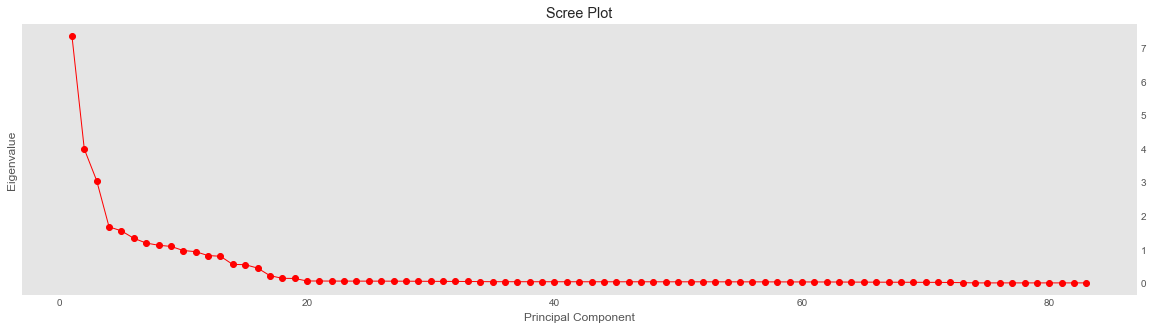

In [41]:
# scree plot
num_vars= len(features)
fig = plt.figure(figsize=(20,5))
sing_vals = np.arange(num_vars) + 1

plt.plot(sing_vals, eigval, 'ro-', linewidth=1)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(); plt.show()

<p> For this dataset, 9 components should be shortlisted for consideration based on eigenvalues because
Kaiser rule calls for 1.0 cut-off. The first 9 components explains 77.64% of the data. But the scree plot does not tally with the data, it bends at around 4th PC.</p>

<h2> Drop Some Weather Data that seem irrelevant </h2>

In [42]:
#read train data
train = pd.read_csv('training_20min_avg_travel_time.csv') 
cat_columns = ["intersection_id","tollgate_id","hour"]
df_train = pd.get_dummies(train, prefix_sep="__",
                              columns=cat_columns)

In [43]:
train_data = df_train
train_data.drop(['averagetravltime','time_window','date','month','day','minute','pressure','sea_pressure','temperature'], axis=1, inplace=True)
train_data.shape

(25592, 49)

In [44]:
result = base_pred(train_data,train_label)

C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\meiro\.conda\envs\issmv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 38.256054
MAPE: 0.238887


<p> no much impact to the result </p>

<h2> Hyperparameter Tuning </h2>

In [45]:
train = pd.read_csv('training_20min_avg_travel_time.csv') 
cat_columns = ["intersection_id","tollgate_id","hour"]
df_train = pd.get_dummies(train, prefix_sep="__",
                              columns=cat_columns)

In [46]:
train_data = df_train
train_data.drop(['averagetravltime','time_window','date','month','minute',"day","pressure","sea_pressure","temperature","wind_direction","wind_speed"], axis=1, inplace=True)
train_data.shape

(25592, 47)

In [47]:
# Replace the following columns with the log of themselves 
'''If you have variables that always get positive numbers, such as lenght, weight, etc., and that showes 
much more variation with higher values (heteroscedasticity), a log-normal distribution (i.e., normal after 
log-transformation) might be a clearly better description of the data than a normal distribution.
Log-transforming that kind of variables makes the distributions more normally distributed, stabilizes the variances, 
but also makes your model multiplative on the raw scale instead of additive. '''

log_cols = ["lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", 
           "rel_humidity","precipitation","route_length"]

dataframe = train_data

for log_col in log_cols:
    if log_col in dataframe.columns:
        print("Processing column: %s" %(log_col))
        dataframe[log_col] = dataframe[log_col].map(lambda x: max(np.log(x), 0))
    else:
        pass

Processing column: lag1
Processing column: lag2
Processing column: lag3
Processing column: lag4
Processing column: lag5
Processing column: lag6
Processing column: lag7
Processing column: rel_humidity
Processing column: precipitation


C:\Users\meiro\.conda\envs\issmv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


Processing column: route_length


In [48]:
#normalize these columns
train_norm = dataframe

norm_type = "mean-std"

for log_col in log_cols:
    print("Processing column: %s" %(log_col))
    tr_values = train_norm[log_col]
    
    if norm_type == "min-max":
        train_norm[log_col] = (tr_values - np.min(tr_values))/(np.max(tr_values) - np.min(tr_values))
        train_norm[log_col] = train_norm[log_col].astype("float64")
        
    elif norm_type == "mean-std":
        train_norm[log_col] = (tr_values - np.min(tr_values))/np.std(tr_values)
        train_norm[log_col] = train_norm[log_col].astype("float64")
    else:
        pass

Processing column: lag1
Processing column: lag2
Processing column: lag3
Processing column: lag4
Processing column: lag5
Processing column: lag6
Processing column: lag7
Processing column: rel_humidity
Processing column: precipitation
Processing column: route_length


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost.sklearn import XGBRegressor

xgb1 = XGBRegressor()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.02,0.04, 0.06], #so called `eta` value
              'max_depth': [6, 8, 10],
              'min_child_weight': [8],
              'silent': [1],
              'subsample': [0.9],
              'colsample_bytree': [0.8],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

X_train, X_test, y_train, y_test = train_test_split(train_norm, train_label, test_size=0.2, random_state=123)

xgb_grid.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [53]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

test_err = mape(y_test, preds)
print ("MAPE: %f" % (test_err))


RMSE: 38.365636
MAPE: 0.238464
